In [1]:
import pandas as pd
pd.options.display.max_columns = None

data = pd.read_csv('data/train.csv')

In [2]:
import regex as re

In [3]:
data.shape

(4167, 74)

Comenzaremos eliminando las columnas que decidimos descartar de mara directa en la exploración inicial.

In [4]:
columns = ['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'listing_url', 'scrape_id', 'last_scraped',
           'picture_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'calendar_last_scraped', 'license']

data.drop(columns, axis=1, inplace=True)

In [5]:
data.shape

(4167, 61)

Cuanto mayor sea el número de columnas, más complicado será trabajar con ellas. Por eso lo que haremos será reducirlas mucho (aun sabiendo que algunas de las que descartamos pueden aportar valor a nuestro modelo) y a partir de ahí trataremos de afinar el modelo incluyendo algunas de esas columnas eliminadas (si lo considerásemos oportuno).

Empezamos dropeando las columnas que sospechamos que no aportan valor (sin entrar en profundidad en los datos, ya sea por la información que aportan los datos o por el formato en el que se nos proporcionan). También haremos algunas comprobacionas con las que tengamos dudas más específicas.

In [6]:
columns = ['name', 'description', 'neighborhood_overview', 'host_name', 'host_location', 'host_about', 'host_listings_count',
          'neighbourhood', 'property_type', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
          'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
          'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365',
          'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
          'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
          'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']

cleaning = data.drop(columns, axis=1)

In [7]:
cleaning.shape

(4167, 28)

In [8]:
cleaning.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'price', 'minimum_nights', 'number_of_reviews', 'first_review',
       'last_review', 'review_scores_rating', 'instant_bookable',
       'reviews_per_month'],
      dtype='object')

Una vez hecha la limpieza general, vamos fila por fila para transformar los datos según consideremos oportuno.

**'host_since'**: los valores son fechas en tipo string. Lo que haremos será establecer como valor el año (en formato int) en lugar de la fecha completa. Esto lo hacemos en base a la creencia de que el año de registro del host influye en el precio esablecido.

In [9]:
cleaning.host_since[0]

'2012-07-24'

In [10]:
cleaning.host_since = cleaning.host_since.apply(lambda x: int(x[:4]))

In [11]:
cleaning.host_since.value_counts()

2014    705
2013    641
2015    585
2016    511
2012    407
2019    303
2018    289
2017    252
2020    170
2021    146
2011    125
2010     29
2009      3
2008      1
Name: host_since, dtype: int64

**'host_response_time'**: tiene cuatro valores únicos que indican la rapidez de respuesta del host. Podemos entenderlo como una escala ordinal por lo que lo trataremos como tal. Es cierto que este orden no debería ser homogéneo, es decir, no es lo mismo el salto de una hora a unas pocas horas que de un día a varios días o más. No tenemos una base real para esto, por lo que simplificaremos bastante esta distinción. Lo que haremos será "penalizar" a aquellos hosts que responden en varios días o más (entendemos que es el tiempo de respuesta al que el usuario es más sensible).

In [12]:
cleaning.host_response_time.value_counts()

within an hour        1550
within a few hours     573
within a day           556
a few days or more      75
Name: host_response_time, dtype: int64

In [13]:
cleaning.host_response_time = cleaning.host_response_time.replace(['within an hour', 'within a few hours', 'within a day', 'a few days or more'],
                                    [1, 2, 3, 5])

Una vez hecha la transformación nos damos cuenta de que la cantidad de NaN es excesiva y no tendría mucho sentido definir valores sin saber cuál es realmente el tiempo de respuesta (al menos, según nuestro planteamiento). Entedemos que la presencia de NaN no es algo que dependa del host o de la propia plataforma Airbnb, sino que se debe a fallos en la extracción de los datos, lo cual complica aún más el manejo de los valores nulos. Decidimos eliminar la columna 'host_response_time'.

In [14]:
cleaning.host_response_time.isnull().sum()

1413

In [15]:
cleaning.drop('host_response_time', axis=1, inplace=True)

**'host_response_rate'**: siguiendo el planteamiento anterior (gran proporción de NaN y dificultad para gestionarlos), decidimos eliminar esta columna.

In [16]:
cleaning.host_response_rate.isnull().sum()

1413

In [17]:
cleaning.drop('host_response_rate', axis=1, inplace=True)

**'host_acceptance_rate'**: en la linea de lo anterior y teniendo en cuenta que ya dudábamos de la aportación de valor de esta columna, también decidimos eliminar esta columna.

In [18]:
cleaning.host_acceptance_rate.isnull().sum()

1092

In [19]:
cleaning.drop('host_acceptance_rate', axis=1, inplace=True)

**'host_is_superhost'**: los valores son 'f' (false) o 't' (true) en formato string. No hay NaN ni ningún otro valor. Simplemente lo que haremos será sustituir 'f' por 0 y 't' por 1 (en formato int lógicamente).

In [20]:
cleaning.host_is_superhost.value_counts()

f    3081
t    1086
Name: host_is_superhost, dtype: int64

In [21]:
cleaning.host_is_superhost = cleaning.host_is_superhost.replace(['f', 't'], [0, 1])

In [22]:
cleaning.host_is_superhost.value_counts()

0    3081
1    1086
Name: host_is_superhost, dtype: int64

**'host_neighbourhood'**: nos damos cueta de que ya existe otra columna que hace referencia al barrio ('neighbourhood_cleansed') y además esta otra columna tiene un formato más amigable (22 valores únicos). Decidimos eliminar esta columna.

In [23]:
len(cleaning.host_neighbourhood.unique())

52

In [24]:
len(cleaning.neighbourhood_cleansed.unique())

22

In [25]:
cleaning.drop('host_neighbourhood', axis=1, inplace=True)

**'host_total_listings_count'**: nos indica la cantidad de propiedades listadas por el host. Entendemos que esto puede influir en el precio ya que, a mayor número de propiedades, más competitivo podrá ser el precio (especialmente si se trata de inmobiliarias o similares). No contiene valores nulos, por lo que mantenemos la columna como está.

In [26]:
cleaning.host_total_listings_count.isnull().sum()

0

**'host_verifications'**: es una columna bastante incómoda de tratar. Viene en formato lista y contiene (o no) diferentes valores en cada caso. Lo que haremos será hacer un recuento de los diferentes tipos de verificación para ese host y establecer este recuento como valor (entendiendo que a mayor cantidad, mayor fiabilidad o facilidad para el usuario).

In [27]:
def limpieza_lista(x):
    x = x.lstrip("['")
    x = x.rstrip("']")
    x = x.split("', '")
    return len(x)

In [28]:
cleaning.host_verifications = cleaning.host_verifications.apply(limpieza_lista)

In [29]:
cleaning.host_verifications.value_counts()

4     700
5     629
8     553
7     537
2     500
6     489
3     423
9     191
1      90
10     45
11     10
Name: host_verifications, dtype: int64

**'host_has_profile_pic'**: nos damos cuenta de que sólo hay 12 valores 'f' y el resto son 't'. Esto no aportará valor a nuestro modelo, por lo que eliminamos la columna.

In [30]:
cleaning.host_has_profile_pic.value_counts()

t    4155
f      12
Name: host_has_profile_pic, dtype: int64

In [31]:
cleaning.host_has_profile_pic.isnull().sum()

0

In [32]:
cleaning.drop('host_has_profile_pic', axis=1, inplace=True)

**'host_identity_verified'**: seguimos el mismo planteamiento que en 'host_is_superhost', sustituyendo los valores que son 'f' 'f' por 0 y los 't' por 1 (en formato int lógicamente).

In [33]:
cleaning.host_identity_verified.value_counts()

t    3355
f     812
Name: host_identity_verified, dtype: int64

In [34]:
cleaning.host_identity_verified = cleaning.host_identity_verified.replace(['f', 't'], [0, 1])

In [35]:
cleaning.host_identity_verified.value_counts()

1    3355
0     812
Name: host_identity_verified, dtype: int64

**'cleaning.neighbourhood_cleansed'**: contiene 22 valores únicos referentes al barrio. Generaremos variables ficticias a través de un get_dummies.

In [36]:
len(cleaning.neighbourhood_cleansed.unique())

22

In [37]:
cleaning.neighbourhood_cleansed.isnull().sum()

0

In [38]:
cleaning.neighbourhood_cleansed.value_counts()

Centrum-West                              639
De Baarsjes - Oud-West                    611
Centrum-Oost                              470
De Pijp - Rivierenbuurt                   423
Zuid                                      275
Westerpark                                266
Oud-Oost                                  241
Bos en Lommer                             193
Oud-Noord                                 188
Oostelijk Havengebied - Indische Buurt    166
IJburg - Zeeburgereiland                  111
Watergraafsmeer                           108
Noord-West                                 88
Noord-Oost                                 76
Slotervaart                                68
Geuzenveld - Slotermeer                    58
Buitenveldert - Zuidas                     44
De Aker - Nieuw Sloten                     38
Gaasperdam - Driemond                      32
Osdorp                                     29
Bijlmer-Centrum                            28
Bijlmer-Oost                      

In [39]:
barrio = pd.get_dummies(cleaning.neighbourhood_cleansed)

In [40]:
cleaning = pd.concat([cleaning, barrio], axis=1)

In [41]:
cleaning.drop('neighbourhood_cleansed', axis=1, inplace=True)

**'latitude' & 'longitude'**: aunque puede parecer un poco confuso y no sabemos si realmente aportará valor al modelo, dejamos estas columnas tal cual están (teniendo en cuenta que no existen valores nulos) y que estas columnas son tipo float.

In [42]:
cleaning.latitude.isnull().sum()

0

In [43]:
cleaning.longitude.isnull().sum()

0

In [44]:
cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      4167 non-null   int64  
 1   host_since                              4167 non-null   int64  
 2   host_is_superhost                       4167 non-null   int64  
 3   host_total_listings_count               4167 non-null   int64  
 4   host_verifications                      4167 non-null   int64  
 5   host_identity_verified                  4167 non-null   int64  
 6   latitude                                4167 non-null   float64
 7   longitude                               4167 non-null   float64
 8   room_type                               4167 non-null   object 
 9   accommodates                            4167 non-null   int64  
 10  bathrooms_text                          4159 non-null   obje

**'room_type'**: solo existen cuatro posibles valores para esta columna (y no encontramos NaN). Decidimos generar variables ficticias a través de pd.get_dummies()

In [45]:
cleaning.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [46]:
room_type = pd.get_dummies(cleaning.room_type)

In [47]:
cleaning = pd.concat([cleaning, room_type], axis=1)

In [48]:
cleaning.drop('room_type', axis=1, inplace=True)

**'accommodates'**: indica la capacidad de huéspedes. No hay problemas aparentes en los datos (más allá de dos valores 0; lo cual no tiene sentido), por lo que dejamos la columna como está.

In [49]:
cleaning.accommodates.isnull().sum()

0

In [50]:
cleaning.accommodates.unique()

array([ 3,  4,  2,  6,  1,  5, 14,  7, 16, 12,  8,  0, 13, 10])

In [51]:
cleaning.accommodates.value_counts()

2     2196
4     1309
3      302
1      117
6      107
5       79
8       18
7       15
16      13
12       5
14       2
0        2
13       1
10       1
Name: accommodates, dtype: int64

**'bathrooms_text'**: indica la cantidad de baños. Los valores vienen en una string que contiene un dígito con el número de baños y especifica el tipo de baño del que se trata o las condiciones de su uso. No entraremos a valorar el tipo de baño y únicamente extraeremos el dígito contenido en la string.

También encontramos 8 valores NaN. Lo primero que haremos será rellenarlos con 0 (entendemos que si no ponen nada es porque no tienen). Luego estableceremos el resto de valores con el dígito contenido en el texto (en los que no contienen dígitos, el texto hace referencia a un half-bath, por lo que definiremos el valor como 0.5).

In [52]:
cleaning.bathrooms_text.unique()

# Nos damos cuenta de los que no tienen dígitos se correponden con 0.5 bathrooms.

array(['1.5 shared baths', '1 bath', '1 private bath', '1.5 baths',
       '2.5 baths', '1 shared bath', '2 baths', '3.5 shared baths',
       '3 baths', 'Half-bath', 'Shared half-bath', '0 baths', nan,
       '4 shared baths', '3.5 baths', '5 baths', '3 shared baths',
       '0 shared baths', '2 shared baths', 'Private half-bath',
       '4.5 baths', '5.5 baths', '4 baths'], dtype=object)

In [53]:
cleaning.bathrooms_text.isnull().sum()

8

In [54]:
cleaning.bathrooms_text.fillna('0.0', inplace=True)

In [55]:
cleaning.bathrooms_text.isnull().sum()

0

In [56]:
def baños_digit (x):
    try:
        digit = re.findall('\d.?\d?', x)
        return float(digit[0])
    except:
        return 0.5  # Los que no contienen dígitos los definimos como 0.5

In [57]:
cleaning.bathrooms_text = cleaning.bathrooms_text.apply(baños_digit)

In [58]:
cleaning.bathrooms_text.value_counts()

1.0    2517
1.5    1207
2.0     231
2.5      88
3.0      45
0.0      30
0.5      22
3.5      19
4.0       3
5.0       2
4.5       2
5.5       1
Name: bathrooms_text, dtype: int64

**'bedrooms' & 'beds'**: sospechamos que estas dos columnas pueden tener una colinealidad elevada con alguna de las que ya tenemos hasta ahora (accommodates, por ejemplo), así que dejamos pendiente la limpieza de estas dos columnas para cuando hayamos testeado esta hipótesis (no las limpiaremos si existe colinealidad y las vamos a eliminar).

In [73]:
cleaning.bedrooms.isnull().sum()

253

In [74]:
cleaning.beds.isnull().sum()

174

**'amenities'**: es una lista con los amenities que ofrece el hospedaje en cuestión. Seguimos el mismo razonamiento que en 'host_verifications'. Tendremos en cuenta el número de amenities que ofrece, más allá de los amenities en sí. Por tanto, sustituiremos el valor por la longitud de la lista de amenities para cada registro (nº de amenities).

In [59]:
def limpieza_lista2 (x):
    x = x.lstrip('''["''')
    x = x.rstrip('''"]''')
    x = x.split('''", "''')
    return len(x)

In [60]:
cleaning.amenities = cleaning.amenities.apply(limpieza_lista2)

In [61]:
cleaning.amenities.unique()

array([16, 40, 20, 24, 25, 23, 43, 22,  8, 62, 29, 31, 26, 54, 53, 38, 37,
       39, 51, 21, 47, 17, 18, 28, 41, 27,  6, 34, 52, 15,  7, 45, 33, 30,
       57, 11, 10, 49, 13, 14, 32, 12, 19, 42, 35, 36, 48, 44, 69, 46,  3,
       66, 50, 58, 59,  5, 61,  9, 64, 55,  4, 56, 70,  1, 68,  2, 63, 60,
       71, 72, 65])

**'price'**: es nuestra **columna objetivo** por lo que la dejaremos tal y como está y tendremos especial cuidado en no alterarla.
    

**'minimum_nights'**: no tiene nulos ni valores problemáticos. Sí que parece un poco extraño los valores 1000 y 1001 (incluso 180), pero su frecuencia es muy escasa y asumimos que son valores correctos correspondientes a alquileres de "larga duración". No aplicamos cambios a la columna (más adelante veremos si se trata de outliers que debamos descartar).

In [62]:
cleaning.minimum_nights.isnull().sum()

0

In [63]:
cleaning.minimum_nights.unique()

array([   2,    1,    3,    5,    7,    8,    4,  180,   10,    6,   30,
         26,   28,   15,   25,   20,    9,   12,   29,   14,   19,   18,
         60,   21,   59, 1000,   23, 1001,   13,   17,   11])

In [64]:
cleaning.minimum_nights.value_counts()

2       1432
3       1017
1        818
4        318
5        221
7        187
6         54
14        23
10        20
30        12
28        10
15         7
21         7
20         7
8          6
25         5
12         3
29         3
18         2
60         2
180        2
9          2
19         1
26         1
59         1
1000       1
23         1
1001       1
13         1
17         1
11         1
Name: minimum_nights, dtype: int64

**'number_of_reviews'**: no tiene nulos ni valores problemáticos, así que lo dejamos tal y como está.

In [65]:
cleaning.number_of_reviews.isnull().sum()

0

In [66]:
cleaning.number_of_reviews.unique()

array([ 81,   9,  47,  10, 166, 101,  77,  19,   3,  31,  24,   0,  18,
         8,  88,  25,  39,  20,  45, 117,  82,   1,   2,  27, 321,  33,
       211,  37,   6, 124, 123, 234, 179,  13,   4,  30,  22,  42, 167,
        16,  57, 170, 277, 140,  61,  12,  83,  73, 448,   5, 521,  59,
        85,   7,  76,  40,  11, 523,  15,  14, 275, 106, 108,  38, 414,
        50,  17,  52,  49, 392,  70,  23,  21, 119,  54,  26,  60,  48,
        35,  56,  32,  29,  43,  62,  92,  46,  44,  58, 147, 150, 330,
        36, 100, 171, 377, 131,  79,  51, 260, 218, 315, 127, 412, 142,
       176, 547, 279,  28, 246, 111,  65, 121, 174, 145, 296, 303,  71,
       104,  41, 138,  94,  86, 110, 252,  96,  93, 161, 265, 376,  53,
       238, 157, 196,  75,  64, 169, 107, 213, 901,  55, 187,  72, 129,
       158, 536, 822, 208, 236, 159, 182, 128, 139, 201,  63, 204,  69,
       620, 364, 224, 168, 227,  34, 151, 214, 194,  99, 153,  90, 248,
       126, 292, 264, 243, 135, 268, 535, 302, 105, 295, 133, 34

**'first_review' & 'last_review'**: a estas columnas le aplicaremos la misma transformación que hicimos antes con las fechas de 'host_since'. Nos quedaremos solo con el año, sin descartar a priori estas dimensiones. No obstante, es probable que nos den problemas más adelante (no aporten al modelo o generen colinealidad, por ejemplo), por lo que deberemos tener esto en cuenta más adelante.

Además, encontramos valores NaN en ambas columnas. Comprobamos que estos registros son aquellos en los que no existen reviews. Lo que haremos será sustituit los NaN por 0.

In [67]:
cleaning.first_review.isnull().sum()

377

In [68]:
cleaning.last_review.isnull().sum()

377

In [91]:
# Sospechamos que las filas sin fechas (NaN) de la primera y útima review se corresponde con aquellos que no tienen reviews:

x = cleaning.query('number_of_reviews == 0') # Filtramos aquellos en los que el nº de reviews es 0.

x.info() # Nos fijamos en que 'first_review' y 'last_review' son todo NaN, así que confirmamos nuestra hipótesis.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 11 to 4165
Data columns (total 47 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      377 non-null    int64  
 1   host_since                              377 non-null    int64  
 2   host_is_superhost                       377 non-null    int64  
 3   host_total_listings_count               377 non-null    int64  
 4   host_verifications                      377 non-null    int64  
 5   host_identity_verified                  377 non-null    int64  
 6   latitude                                377 non-null    float64
 7   longitude                               377 non-null    float64
 8   accommodates                            377 non-null    int64  
 9   bathrooms_text                          377 non-null    float64
 10  bedrooms                                359 non-null    floa

In [99]:
# Limpiamos las columnas.

def reviews_date(x):
    try:
        x = int(x[:4])
        return x
    except:
        x = 0     # Deberemos obtener 377 ceros, correspondientes a los NaN.
        return x
        
cleaning.first_review = cleaning.first_review.apply(reviews_date)

cleaning.last_review = cleaning.last_review.apply(reviews_date)

In [100]:
cleaning.first_review.value_counts()  # Checkeamos que es correcto (377 NaN).

2019    675
2021    657
2018    554
2017    485
2016    458
2020    377
0       377
2015    272
2014    206
2013     75
2012     25
2011      6
Name: first_review, dtype: int64

In [101]:
cleaning.last_review.value_counts()   # Checkeamos que es correcto (377 NaN).

2021    1706
2019    1078
2020     558
0        377
2018     266
2017     106
2016      50
2015      20
2014       4
2013       2
Name: last_review, dtype: int64

**'review_scores_rating'**: encontramos valores nulos y ocurre lo mismo que en el caso anterior (lógicamente los que no tienen reviews no tienen un score). Aquí la gestión de los NaN es algo complicada. Lo más lógico es sustituir los NaN por ceros (si no tienen score, el score será cero), pero esto puede no ser del todo correcto (de cara al usuario no es lo mismo no tener valoración, que tener una valoración de 0). Es probable que una valoración de 0 penalice más que no tener valoración, por lo que esta transformación no es del todo correcta. Sin embargo, consideramos que es la opción más válida y será lo que haremos. 

In [103]:
cleaning.review_scores_rating.isnull().sum()

377

In [110]:
cleaning.review_scores_rating.fillna(0, inplace=True)

In [111]:
cleaning.review_scores_rating.isnull().sum()

0

**'instant_bookable'**: existen dos valores únicos ('f' si es false o 't' si es true) y no encontramos valores tipo NaN. Haremos la misma transformación que en otras columnas en 'host_is_superhost', donde ocurría lo mismo: sustituiremos 'f' por 0 y 't' por 1.

In [112]:
cleaning.instant_bookable.isnull().sum()

0

In [113]:
cleaning.instant_bookable.value_counts()

f    2785
t    1382
Name: instant_bookable, dtype: int64

In [114]:
cleaning.instant_bookable = cleaning.instant_bookable.replace(['f', 't'], [0, 1])

In [115]:
cleaning.instant_bookable.value_counts()

0    2785
1    1382
Name: instant_bookable, dtype: int64

**'reviews_per_month'**: ocurre algo muy similar que con otras columnas referentes a las reviews. Encontramos 377 valores tipo NaN que se corresponden con aquellos registros en los que no hay reviews. De manera muy intuitiva, decidimos sustituir los NaN por 0 (si el valor es nulo quiere decir que no hay reviews, por lo que el registro tiene 0 reviews al mes).

In [117]:
cleaning.reviews_per_month.isnull().sum()

377

In [119]:
cleaning.reviews_per_month.fillna(0, inplace=True)

**'id'**: no tiene ningún sentido conservar esta columna para desarrollar el modelo. Hasta ahora la hemos conservado para tenerlo como elemento de control y comprobar que no ha habido desajustes en las filas. Observamos que el id coincide con el index, por lo que descartamos cambios o desajustes no deseado. Eliminamos esta columna. 

In [122]:
cleaning.tail()

,id,host_since,host_is_superhost,host_total_listings_count,host_verifications,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,last_review,review_scores_rating,instant_bookable,reviews_per_month,Bijlmer-Centrum,Bijlmer-Oost,Bos en Lommer,Buitenveldert - Zuidas,Centrum-Oost,Centrum-West,De Aker - Nieuw Sloten,De Baarsjes - Oud-West,De Pijp - Rivierenbuurt,Gaasperdam - Driemond,Geuzenveld - Slotermeer,IJburg - Zeeburgereiland,Noord-Oost,Noord-West,Oostelijk Havengebied - Indische Buurt,Osdorp,Oud-Noord,Oud-Oost,Slotervaart,Watergraafsmeer,Westerpark,Zuid,Entire home/apt,Hotel room,Private room,Shared room
4162,4162,2012,0,2,6,1,52.354910,4.886640,2,1.0,1.0,1.0,21,95.0,2,15,2019,2019,4.93,0,0.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4163,4163,2012,0,0,5,1,52.381270,4.870390,2,1.0,1.0,2.0,46,65.0,1,2,2021,2021,5.00,1,1.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4164,4164,2017,1,1,6,1,52.357910,4.921930,3,1.0,2.0,3.0,51,114.0,1,5,2021,2021,5.00,0,3.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4165,4165,2020,1,0,2,1,52.361374,4.883171,3,1.0,1.0,2.0,33,416.0,1,0,0,0,0.00,1,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4166,4166,2013,1,2,8,1,52.354710,4.869830,4,1.5,3.0,3.0,30,292.0,5,40,2016,2020,4.88,0,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [126]:
cleaning.drop('id', axis=1, inplace=True)

In [155]:
cleaning.head()

,host_since,host_is_superhost,host_total_listings_count,host_verifications,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,last_review,review_scores_rating,instant_bookable,reviews_per_month,Bijlmer-Centrum,Bijlmer-Oost,Bos en Lommer,Buitenveldert - Zuidas,Centrum-Oost,Centrum-West,De Aker - Nieuw Sloten,De Baarsjes - Oud-West,De Pijp - Rivierenbuurt,Gaasperdam - Driemond,Geuzenveld - Slotermeer,IJburg - Zeeburgereiland,Noord-Oost,Noord-West,Oostelijk Havengebied - Indische Buurt,Osdorp,Oud-Noord,Oud-Oost,Slotervaart,Watergraafsmeer,Westerpark,Zuid,Entire home/apt,Hotel room,Private room,Shared room
0,2012,0,13,8,1,52.39508,4.99186,3,1.5,1.0,NaN,16,87.0,2,81,2014,2019,4.62,0,0.91,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2015,0,0,3,0,52.36371,4.90745,4,1.0,2.0,2.0,40,250.0,2,9,2020,2021,5.00,0,0.40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018,1,20,2,1,52.35482,4.85329,2,1.0,1.0,1.0,20,151.0,1,47,2018,2020,4.79,1,1.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,2016,0,1,3,0,52.36446,4.85972,2,1.5,1.0,1.0,24,139.0,2,10,2019,2019,5.00,0,0.31,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2013,1,1,9,1,52.34176,4.84782,2,1.5,1.0,2.0,25,95.0,2,166,2014,2019,4.67,0,1.78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


## Análisis Exploratorio: correlaciones y valores atípicos.

In [131]:
cleaning.shape

(4167, 46)

In [156]:
non_dummies = cleaning[['host_since','host_is_superhost', 'host_total_listings_count', 'host_verifications',
                        'host_identity_verified', 'latitude', 'longitude', 'accommodates', 'bathrooms_text',
                        'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'number_of_reviews', 'first_review',
                        'last_review', 'review_scores_rating', 'instant_bookable', 'reviews_per_month']]

In [157]:
non_dummies.head()

,host_since,host_is_superhost,host_total_listings_count,host_verifications,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,last_review,review_scores_rating,instant_bookable,reviews_per_month
0,2012,0,13,8,1,52.39508,4.99186,3,1.5,1.0,NaN,16,87.0,2,81,2014,2019,4.62,0,0.91
1,2015,0,0,3,0,52.36371,4.90745,4,1.0,2.0,2.0,40,250.0,2,9,2020,2021,5.00,0,0.40
2,2018,1,20,2,1,52.35482,4.85329,2,1.0,1.0,1.0,20,151.0,1,47,2018,2020,4.79,1,1.25
3,2016,0,1,3,0,52.36446,4.85972,2,1.5,1.0,1.0,24,139.0,2,10,2019,2019,5.00,0,0.31
4,2013,1,1,9,1,52.34176,4.84782,2,1.5,1.0,2.0,25,95.0,2,166,2014,2019,4.67,0,1.78


In [139]:
import pylab as plt
import seaborn as sns
import numpy as np

In [158]:
corr = non_dummies.corr()

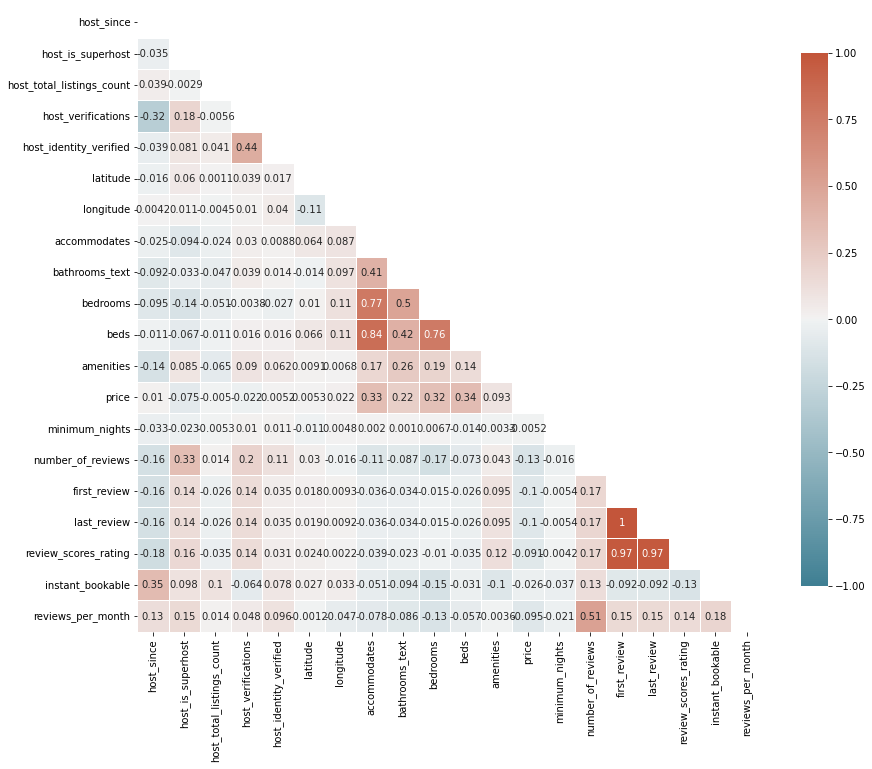

In [161]:
plt.figure(figsize=(14,14)) 

mascara = np.triu(np.ones_like(non_dummies.corr(), dtype=bool)) # generamos la máscara para la triangular superior

color_map = sns.diverging_palette(220, 20, as_cmap=True) # Paleta de colores

sns.heatmap(non_dummies.corr(),  
            mask = mascara,
            cmap=color_map,
            square=True, #que los datos se vean como cuadrados
            linewidth=0.5, #ancho de línea
            vmax=1,
            vmin=-1,
            annot=True,
            cbar_kws={"shrink": .7},# barra lateral
);

**Conclusiones matriz de correlación**:
- 'last_review' y 'first_review' están perfectamente correlacionadas.
- 'last_review' y 'first_review' están muy correlacionadas (0.97) con 'review_scores_rating'.
- 'bedrooms' y 'beds' están bastante correlacionadss con 'accommodates'. Además, 'bedrooms' y 'beds' están bastante correlacionadss entre ellas y tienen correlación (no tan elevada) con otras dimensiones.
- Hay una correlación relativamente elevada (0.51) entre 'number_of_reviews' y 'reviews_per_month'.
- Hay una correlación relativamente elevada (0.44) entre 'host_identity_verified' y 'host_verifications'.
- Hay una correlación relativamente elevada (0.41) entre 'bathroom_text' y 'accommodates'.

**Decisiones**:
- Eliminamos 'last_review'.
- Eliminamos 'first_review'.
- Eliminamos 'bedrooms'.
- Eliminamos 'beds'.
- Prestaremos atención a 'number_of_reviews' y 'reviews_per_month'.
- Prestaremos atención a 'host_identity_verified' y 'host_verifications'.
- Prestaremos atención a 'bathroom_text' y 'accommodates'.

Eliminamos las columnas que mantienen fuerte correlación con otras.

In [162]:
cleaning.drop(['last_review', 'first_review', 'bedrooms', 'beds'] , axis=1, inplace=True)

In [ ]:
cleaning.info()